# 自动微分  

### 1. 标量变量的反向传播

作为一个演示例子，假设我们想对函数$y=2\bold{x}^\top\bold{x}$关于列向量$\bold x$求导。  

In [4]:
import torch

x = torch.arange(4.0)
x.requires_grad_() # start to record operations done to x，开始绘制计算图
y = 2 * torch.dot(x, x) # 对x执行某种操作
print(y)

tensor(28., grad_fn=<MulBackward0>)


接下来，通过调用反向传播函数来自动计算y关于x每个分量的梯度，并打印这些梯度。  

In [5]:
y.backward() # 反向传播
x.grad # 梯度保存在x.grad

tensor([ 0.,  4.,  8., 12.])

现在计算y = sum(x)的梯度

In [6]:
x.grad.zero_() # 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### 2. 非标量变量的反向传播

In [11]:
x.grad.zero_()
x.requires_grad_()
y = x * x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### 3. 分离计算

反向传播时将某些部分作为常数处理。  

In [16]:
x.grad.zero_()
y = x * x
u = y.detach() # 将y作为常数u
z = u * x
z.sum().backward() # 反向传播时不会对u（y）再求导
x.grad == u

tensor([True, True, True, True])

In [17]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

### 4.  Python控制流的梯度计算

构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。  

In [19]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()
print(a)
print(a.grad == d / a)

tensor(1.8156, requires_grad=True)
tensor(True)


### 5. 练习

- 使f(x) = sin(x)，绘制$\frac{\,df}{\,dx}$的图像，其中后者不使用f′(x) = cos(x)。

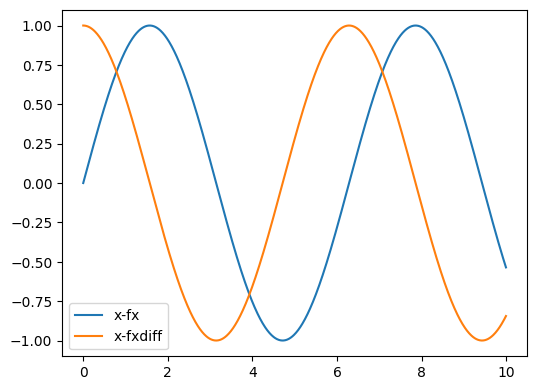

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

x = torch.arange(0, 10.0, 0.01, requires_grad=True)
fx = x.sin()
fxdiff = fx.backward(gradient=torch.ones(len(x)))
figze = plt.figure(figsize=(6, 4.5))
axes = figze.subplots()

# 对带有梯度的变量直接用plot()会导致计算图被破坏，应进行变量分离，即x.detach()
axes.plot(x.detach().numpy(), fx.detach().numpy(), label="x-fx") 
axes.plot(x.detach().numpy(), x.grad, label="x-fxdiff")
axes.legend()

- 两个自动微分的关键方法及其意义  
`torch.Tensor.requires_grad_(requires_grad=Ture)`的作用：记录当前tensor的操作，即构建计算图。  
`torch.Tensor.backward()`的作用：反向传播，计算梯度。  

- `torch.Tensor.backward()`的用法:  
    ```Python
    (method) def backward(
        gradient: Any | None = None,
        retain_graph: Any | None = None,
        create_graph: bool = False,
        inputs: Any | None = None
    ) -> (Any | None)
    ```  
    
    `gradient`:用于将非标量Tensor转换成标量的Tensor。举一个例子： 
    
    ![gradient的详细解释](picture\grad.jpg)  

    
    `retain_graph`：通常在调用一次backward后，***pytorch会自动把计算图销毁，当计算图被销毁后，对调用backward()的该变量进行任何操作都不会再影响构建它的leaf tensor了***。要想对某个变量重复调用backward，则需要将该参数设置为True。  